# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [454]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [455]:
import pandas as pd
import numpy as np
import math
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from time import time
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
%matplotlib inline

##  Data Exploration

#### 1. Portfolio data

In [456]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [457]:
portfolio.isnull().sum()/portfolio.shape[0] * 100

channels      0.0
difficulty    0.0
duration      0.0
id            0.0
offer_type    0.0
reward        0.0
dtype: float64

In [458]:
# check no. of unique offers
print("No. of unique offers: {}".format(portfolio.id.nunique()))

# no. of unique offers by offer type
print(portfolio.groupby('offer_type')['id'].count())

No. of unique offers: 10
offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64


#### 2. Demographic data

In [459]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [460]:
print(profile.isnull().sum()/profile.shape[0] * 100)
print("no. unique people: {}".format(profile['id'].nunique()))

age                  0.000000
became_member_on     0.000000
gender              12.794118
id                   0.000000
income              12.794118
dtype: float64
no. unique people: 17000


no. user with age = 118: 2175


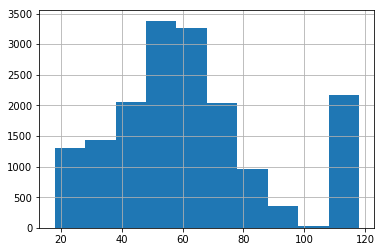

In [461]:
profile.age.hist()
# print(profile['age'].value_counts())
print("no. user with age = 118: {}".format(profile[profile['age'] == 118]['age'].count()))

M    8484
F    6129
O     212
Name: gender, dtype: int64


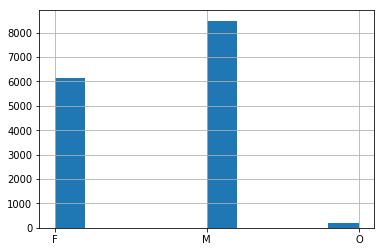

In [462]:
profile.gender.hist()
print(profile['gender'].value_counts())

#### 3. Transactional records

In [463]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [464]:
event_counts = transcript['event'].value_counts()
print(event_counts)
print("no. unique people: {}".format(transcript['person'].nunique()))

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64
no. unique people: 17000


In [465]:
transcript.isnull().sum()/transcript.shape[0]*100

event     0.0
person    0.0
time      0.0
value     0.0
dtype: float64

In [467]:
# expand the value into individual columns depending on the even
transcript = pd.concat([transcript, transcript['value'].apply(pd.Series)],axis=1)
transcript.head()

,event,person,time,value,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [468]:
#create new column to ensure only one offer_id column
transcript['new offer id']=np.where(transcript['offer id'].notnull() & transcript['offer_id'].isnull(),transcript['offer id'],transcript['offer_id'])

#drop unnecessary offer_id columns
transcript.drop(['offer id','offer_id','value'],axis=1,inplace=True)

#rename offer_id column
transcript.rename(columns={'new offer id':'offer_id'},inplace=True)

transcript.head()

,event,person,time,amount,reward,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


## Data preprocessing

#### 1. Assigning offer ids to transactions

In [469]:
transcript[transcript['event'] == 'transaction'].head()

,event,person,time,amount,reward,offer_id
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,0.83,NaN,NaN
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,NaN,NaN
12659,transaction,54890f68699049c2a04d415abc25e717,0,13.23,NaN,NaN
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,NaN,NaN
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,NaN,NaN


In [470]:
# sort events by person and time
transcript = transcript.sort_values(['person','time'])
transcript.head()

,event,person,time,amount,reward,offer_id
55972,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
89291,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,NaN,NaN
113605,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,NaN,3f207df678b143eea3cee63160fa8bed
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,NaN,3f207df678b143eea3cee63160fa8bed


In [471]:
# forward fill offer ides by person for transactions that occur after an offer is viewed
transaction = transcript[(transcript['event']=='transaction') | (transcript['event']=='offer viewed')].groupby(['person','offer_id']).ffill()
transaction['offer_id']=transaction['offer_id'].ffill()
transaction.head()

,person,offer_id,event,time,amount,reward
77705,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,offer viewed,192,NaN,NaN
89291,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,transaction,228,22.16,NaN
139992,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,offer viewed,372,NaN,NaN
168412,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,transaction,414,8.57,NaN
187554,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,offer viewed,456,NaN,NaN


In [472]:
transcript = transcript.merge(transaction[['person','time','event','offer_id']],how='left',on=['person','time','event'])
transcript.head()

,event,person,time,amount,reward,offer_id_x,offer_id_y
0,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837
2,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
3,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,NaN,3f207df678b143eea3cee63160fa8bed,NaN
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,NaN,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed


In [473]:
transcript['offer_id'] = np.where(transcript['offer_id_x'].isnull(),transcript['offer_id_y'],transcript['offer_id_x'])
transcript.head()

,event,person,time,amount,reward,offer_id_x,offer_id_y,offer_id
0,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,5a8bc65990b245e5a138643cd4eb9837
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837
2,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837
3,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,NaN,3f207df678b143eea3cee63160fa8bed,NaN,3f207df678b143eea3cee63160fa8bed
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,NaN,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed


In [474]:
transcript.drop(['offer_id_x','offer_id_y'],axis=1,inplace=True)
transcript.head()

,event,person,time,amount,reward,offer_id
0,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
2,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,NaN,5a8bc65990b245e5a138643cd4eb9837
3,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,NaN,3f207df678b143eea3cee63160fa8bed
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,NaN,3f207df678b143eea3cee63160fa8bed


In [475]:
# explore kind of events within each offer type
portfolio.rename(columns={'id':'offer_id'},inplace=True)

#join transcript with offer type
transcript=transcript.merge(portfolio, how='left',on='offer_id')

In [476]:
transcript.head()

,event,person,time,amount,reward_x,offer_id,channels,difficulty,duration,offer_type,reward_y
0,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,0
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,0
2,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,0
3,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,4,informational,0
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,4,informational,0


In [477]:
# drop unnecessay columns in transcript 
transcript = transcript.drop(columns=['reward_x','reward_y'],axis=1,inplace=False)
transcript.head()

,event,person,time,amount,offer_id,channels,difficulty,duration,offer_type
0,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational
2,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational
3,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,4,informational
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,4,informational


In [478]:
transcript.groupby(['event','offer_type'])['offer_type'].count()

event            offer_type   
offer completed  bogo             15669
                 discount         17910
offer received   bogo             30499
                 discount         30543
                 informational    15235
offer viewed     bogo             25449
                 discount         21445
                 informational    10831
transaction      bogo             62188
                 discount         57043
                 informational    19722
Name: offer_type, dtype: int64

#### 2. Flagging transactions and offers completed after offers viewed

In [479]:
offers_flag =transcript[(transcript['event']=='offer viewed') | (transcript['event']=='transaction') | (transcript['event']=='offer completed')].copy()

In [480]:
#add extra column to flag the previous offer id
offers_flag['offer_id_prev'] = offers_flag.groupby(['person','offer_id'])['offer_id'].shift()
offers_flag.head()

,event,person,time,amount,offer_id,channels,difficulty,duration,offer_type,offer_id_prev
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,NaN
2,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,4,informational,NaN
6,transaction,0009655768c64bdeb2e877511632db8f,414,8.57,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
7,offer completed,0009655768c64bdeb2e877511632db8f,414,NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,5,bogo,NaN


In [481]:
#flag a completed transaction/offer completed as long as the previous offer id consists of events in the same sample space
offers_flag['offer completed']=np.where(offers_flag['offer_id_prev']==offers_flag['offer_id'],1,0)
offers_flag.drop('offer_id_prev',axis=1,inplace=True)
offers_flag.head()

,event,person,time,amount,offer_id,channels,difficulty,duration,offer_type,offer completed
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,0
2,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,1
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,4,informational,0
6,transaction,0009655768c64bdeb2e877511632db8f,414,8.57,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,4,informational,1
7,offer completed,0009655768c64bdeb2e877511632db8f,414,NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,5,bogo,0


In [482]:
#get only offer received events
offers_recv=transcript[transcript['event']=='offer received'].copy()

#ensure all columns are the same between datasets to be appended
offers_recv['offer completed']=np.nan

#append datasets to complete dataset of transactions
transcript=offers_recv.append(offers_flag)

#sort values
transcript=transcript.sort_values(['person','time'])
transcript.head()

,event,person,time,amount,offer_id,channels,difficulty,duration,offer_type,offer completed
0,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,NaN
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,0.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,1.0
3,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,4,informational,NaN
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,4,informational,0.0


In [483]:
transcript_bogo=transcript[transcript['offer_type'] == 'bogo']
transcript_disc=transcript[transcript['offer_type'] == 'discount']
transcript_info=transcript[transcript['offer_type'] == 'informational']

In [484]:
def g1(df):
    '''
    get the subset for bogo/discount group1 member
    
    input: transcript dataframe
    
    output: bogo/discount group1 user and offer id
    '''
    g1 = df[(df['offer completed']==1) & (df['event']=='offer completed')][['person','offer_id']].groupby(['person','offer_id']).count().reset_index()
    return g1

bogo_g1 = g1(transcript_bogo)
discount_g1 = g1(transcript_disc)
bogo_g1.head()
discount_g1.head()

,person,offer_id
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7
1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2
2,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4
3,0020ccbbb6d84e358d3414a3ff76cffd,2298d6c36e964ae4a3e7e9706d1fb8c2
4,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4


In [485]:
def g_2_4(df):  
    
    '''
    get the subset for bogo/discount group2/group4 member
    
    input: transcript dataframe
    
    output: bogo/discount group2/group4 user and offer id
    '''

    # subset of transaction and completed
    trans_comp = df[(df['event']=='transaction') | (df['event']=='offer completed')][['person','offer_id']]#.groupby(['person','offer_id']).count().reset_index()
    
    # subset of received and revied
    recv_rev = df[df['event']=='offer received'][['person','offer_id']].groupby(['person','offer_id']).count().reset_index()
    
    # merge trans_comp and recev_rec
    merge = recv_rev.merge(trans_comp,how='left',on=['person','offer_id'],indicator=True)
    
    #subset to check group 2 and 4
    g_2_4=merge[merge['_merge']=='left_only'] # only received

    #remerge with transcript to get events
    g_2_4=g_2_4.merge(transcript,how='left',on=['person','offer_id'])

    #get group 2: received -> viewed
    g2=g_2_4[g_2_4['event']=='offer viewed'][['person','offer_id']].groupby(['person','offer_id']).count().reset_index() 

    # get group 4: only received
    g_2_4.drop(['_merge'],axis=1,inplace=True)
    g4 = g_2_4.merge(g2,how='left',indicator=True)
    g4 = g4[g4['_merge']=='left_only'].copy() # received no viewed
    
    return g2,g4

bogo_g2,bogo_g4 = g_2_4(transcript_bogo)
discount_g2,discount_g4 = g_2_4(transcript_disc)
bogo_g2.head()

,person,offer_id
0,0063def0f9c14bc4805322a488839b32,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,00857b24b13f4fe0ad17b605f00357f5,f19421c1d4aa40978ebb69ca19b0e20d
2,008d7088107b468893889da0ede0df5c,4d5c57ea9a6940dd891ad53e9dbe8da0
3,0092a132ead946ceb30d11a1ed513d20,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,0092a132ead946ceb30d11a1ed513d20,ae264e3637204a6fb9bb56bc8210ddfd


In [486]:
def effective_offer(g1,g2):
    '''
    inputs: 
    Dataframe contians group1 and group2 users
    
    outputs:
    Returns dataframe with labeled effective offer column
    '''
    #assign effective offer flag column
    g1['effective_offer']=1
    g2['effective_offer']=0

    #append datasets together
    effective_off=g1.append(g2,sort=False)
    return effective_off

bogo_off = effective_offer(bogo_g1,bogo_g2)
discount_off = effective_offer(discount_g1,discount_g2)

#### 3. consider validity of offers in converted transactions from informational offers

In [487]:
# convert time into days
transcript_info['day_offer'] = transcript_info['time']/24

# drop unnecessary columns
transcript_info.drop(['time'],axis=1,inplace=True)

# sort transcript to ensure all event occurring by person and offer
transcript_info = transcript_info.sort_values(['person','day_offer','event','offer_id'])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [488]:
transcript_info['diff_info'] = transcript_info[(transcript_info['event'] == 'offer received') | (transcript_info['event'] == 'transaction')].groupby(['person','offer_id'])['day_offer'].diff()
transcript_info.head()

,event,person,amount,offer_id,channels,difficulty,duration,offer_type,offer completed,day_offer,diff_info
0,offer received,0009655768c64bdeb2e877511632db8f,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,NaN,7.0,NaN
1,offer viewed,0009655768c64bdeb2e877511632db8f,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,0.0,8.0,NaN
2,transaction,0009655768c64bdeb2e877511632db8f,22.16,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,1.0,9.5,2.5
3,offer received,0009655768c64bdeb2e877511632db8f,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,4,informational,NaN,14.0,NaN
4,offer viewed,0009655768c64bdeb2e877511632db8f,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,4,informational,0.0,15.5,NaN


In [489]:
valid_comp = []
for i in range(transcript_info.shape[0]):
    if pd.isna(transcript_info['diff_info'].iloc[i]):
        valid_comp.append(0)
    else:
        if transcript_info['diff_info'].iloc[i] <= transcript_info['duration'].iloc[i]:
            valid_comp.append(1)
        else:
            valid_comp.append(0)
transcript_info['valid_comp'] = valid_comp
transcript_info.head()

,event,person,amount,offer_id,channels,difficulty,duration,offer_type,offer completed,day_offer,diff_info,valid_comp
0,offer received,0009655768c64bdeb2e877511632db8f,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,NaN,7.0,NaN,0
1,offer viewed,0009655768c64bdeb2e877511632db8f,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,0.0,8.0,NaN,0
2,transaction,0009655768c64bdeb2e877511632db8f,22.16,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,3,informational,1.0,9.5,2.5,1
3,offer received,0009655768c64bdeb2e877511632db8f,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,4,informational,NaN,14.0,NaN,0
4,offer viewed,0009655768c64bdeb2e877511632db8f,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,4,informational,0.0,15.5,NaN,0


In [490]:
#separate group 1 in transcript_into
info_g1=transcript_info[['person','offer_id']][(transcript_info['offer completed'] == 1) & (transcript_info['valid_comp'] == 1)].groupby(['person','offer_id']).count().reset_index()
info_g1.head()

,person,offer_id
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837
2,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837
3,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837
4,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed


In [491]:
info_g2,info_g4=g_2_4(transcript_info)
info_g2.head()

,person,offer_id
0,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837
1,0063def0f9c14bc4805322a488839b32,5a8bc65990b245e5a138643cd4eb9837
2,008d7088107b468893889da0ede0df5c,5a8bc65990b245e5a138643cd4eb9837
3,00ae03011f9f49b8a4b3e6d416678b0b,5a8bc65990b245e5a138643cd4eb9837
4,00b18b535d6d4f779dea4dc9ac451478,5a8bc65990b245e5a138643cd4eb9837


In [492]:
info_off = effective_offer(info_g1,info_g2)

## Feature Engineering

#### 1. count of offers received

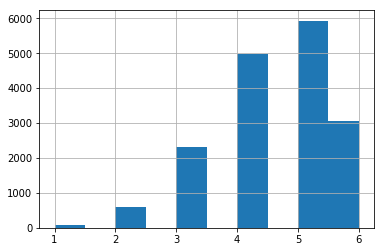

In [493]:
#visualise offers received per person
transcript[transcript['event']=='offer received'].groupby('person')['event'].count().hist()

In [494]:
#get count of offers received per person
off_received_cnt=transcript[transcript['event']=='offer received'].groupby(['person','offer_id','time']).count()['event'].reset_index()
off_received_cnt.rename(columns={'event':'count'},inplace=True)
off_received_cnt.drop('time',axis=1,inplace=True)
off_received_cnt=off_received_cnt.groupby(['person','offer_id']).count().reset_index()
off_received_cnt.head()

,person,offer_id,count
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1


#### 2. separating user behavious by transactions

In [495]:
#filter dataset by invalid transactions
transac_invalid=transcript[(transcript['event']=='transaction') & (transcript['offer completed']==0)].groupby(['person','offer_id'])['amount'].sum().reset_index()
transac_invalid.rename(columns={'amount':'invalid amount'},inplace=True)
transac_invalid.head()

,person,offer_id,invalid amount
0,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,16.27
1,004b041fbfe44859945daa2c7f79ee64,fafdcd668e3743c1bb461111dcafc2a4,25.62
2,0063def0f9c14bc4805322a488839b32,2298d6c36e964ae4a3e7e9706d1fb8c2,2.76
3,0069a50874d846438e58acff5e594725,0b1e1539f2cc45b7b9fa7c272da2e1d7,16.20
4,00715b6e55c3431cb56ff7307eb19675,2906b810c7d4411798c6938adc9daaa5,27.26


## Preparing data 

In [496]:
# clean portfolio data
portfolio['web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
portfolio['email'] = portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
portfolio['mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
portfolio['social'] = portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)

portfolio.head()

,channels,difficulty,duration,offer_id,offer_type,reward,web,email,mobile,social
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0


In [497]:
profile.rename(columns={'id':'person'},inplace=True)

def get_member_day(df):
    '''
    input:
    transcript datafrme
    
    output:
    transcript dataframe merged with profile and became_member_on transformed to tenure in days
    
    '''
    
    df = df.merge(profile,how='left',on='person')
    d = 0
    days = []
    for x in df['became_member_on']:
        year = int(str(x)[:4])
        month = int(str(x)[-3])
        day = int(str(x)[-2:])
        if year == 2018:
            d = 30 * month + day
            days.append(d)
        if year != 2018:
            d = (2018-year) * 365 + 30 * month + day
            days.append(d)
    df['membership_days'] = days
    return df
bogo_off = get_member_day(bogo_off)
discount_off = get_member_day(discount_off)
info_off = get_member_day(info_off)
bogo_off.head()

,person,offer_id,effective_offer,age,became_member_on,gender,income,membership_days
0,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,40,20180109,O,57000.0,39
1,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1,59,20160304,F,90000.0,824
2,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,24,20161111,F,60000.0,771
3,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,1,24,20161111,F,60000.0,771
4,004b041fbfe44859945daa2c7f79ee64,f19421c1d4aa40978ebb69ca19b0e20d,1,55,20180508,F,74000.0,158


In [498]:
bogo_off.drop('became_member_on',axis=1,inplace=True)
discount_off.drop('became_member_on',axis=1,inplace=True)
info_off.drop('became_member_on',axis=1,inplace=True)

#### 1. merge engineered featured to original dataframe

In [499]:
#merge to get offers received count and invalid amount transacted 
bogo_off= bogo_off.merge(off_received_cnt,how='left',on=['person','offer_id'])
bogo_off = bogo_off.merge(transac_invalid,how='left',on=['person','offer_id'])

In [500]:
bogo_off.head()


,person,offer_id,effective_offer,age,gender,income,membership_days,count,invalid amount
0,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,40,O,57000.0,39,1,NaN
1,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1,59,F,90000.0,824,1,NaN
2,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,24,F,60000.0,771,1,NaN
3,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,1,24,F,60000.0,771,1,NaN
4,004b041fbfe44859945daa2c7f79ee64,f19421c1d4aa40978ebb69ca19b0e20d,1,55,F,74000.0,158,1,NaN


In [501]:
(bogo_off.isnull().sum()/len(bogo_off) * 100).sort_values(ascending=False).head()

invalid amount     96.323752
income              7.057489
gender              7.057489
count               0.000000
membership_days     0.000000
dtype: float64

In [502]:
bogo_off.drop('invalid amount',axis=1,inplace=True)

In [503]:
#drop income and gender null rows
bogo_off.dropna(inplace=True)

#merge with portfolio to get offer details
bogo_off=bogo_off.merge(portfolio,how='left',on='offer_id')

In [504]:
bogo_off.head()

,person,offer_id,effective_offer,age,gender,income,membership_days,count,channels,difficulty,duration,offer_type,reward,web,email,mobile,social
0,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,40,O,57000.0,39,1,"[web, email, mobile]",5,7,bogo,5,1,1,1,0
1,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1,59,F,90000.0,824,1,"[web, email, mobile, social]",10,5,bogo,10,1,1,1,1
2,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,24,F,60000.0,771,1,"[web, email, mobile]",5,7,bogo,5,1,1,1,0
3,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,1,24,F,60000.0,771,1,"[web, email, mobile, social]",5,5,bogo,5,1,1,1,1
4,004b041fbfe44859945daa2c7f79ee64,f19421c1d4aa40978ebb69ca19b0e20d,1,55,F,74000.0,158,1,"[web, email, mobile, social]",5,5,bogo,5,1,1,1,1


In [505]:
#get dummy variable encoding function
def get_dummy(df,col):
    dummy = pd.get_dummies(df[col],prefix=col)
    df=pd.concat([df[:],dummy],axis=1,sort=False)
    df = df.drop(col,axis=1)
    return df



In [506]:
bogo_off.drop('channels',axis=1,inplace=True)

#convert gender into categorical variables
bogo_off=get_dummy(bogo_off,'gender')

bogo_off.head()

,person,offer_id,effective_offer,age,income,membership_days,count,difficulty,duration,offer_type,reward,web,email,mobile,social,gender_F,gender_M,gender_O
0,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,40,57000.0,39,1,5,7,bogo,5,1,1,1,0,0,0,1
1,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1,59,90000.0,824,1,10,5,bogo,10,1,1,1,1,1,0,0
2,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,24,60000.0,771,1,5,7,bogo,5,1,1,1,0,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,1,24,60000.0,771,1,5,5,bogo,5,1,1,1,1,1,0,0
4,004b041fbfe44859945daa2c7f79ee64,f19421c1d4aa40978ebb69ca19b0e20d,1,55,74000.0,158,1,5,5,bogo,5,1,1,1,1,1,0,0


In [511]:
# discount offers
discount_off= discount_off.merge(off_received_cnt,how='left',on=['person','offer_id'])
discount_off = discount_off.merge(transac_invalid,how='left',on=['person','offer_id'])

discount_off.drop('invalid amount',axis=1,inplace=True)

#drop income and gender null rows
discount_off.dropna(inplace=True)

#merge with portfolio to get offer details
discount_off=discount_off.merge(portfolio,how='left',on='offer_id')

discount_off.drop('channels',axis=1,inplace=True)

#convert gender into categorical variables
discount_off=get_dummy(discount_off,'gender')


discount_off.head()

,person,offer_id,effective_offer,age,income,membership_days,count,difficulty,duration,offer_type,reward,web,email,mobile,social,gender_F,gender_M,gender_O
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,40,57000.0,39,1,20,10,discount,5,1,1,0,0,0,0,1
1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,40,57000.0,39,1,7,7,discount,3,1,1,1,1,0,0,1
2,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,1,59,90000.0,824,2,10,10,discount,2,1,1,1,1,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,2298d6c36e964ae4a3e7e9706d1fb8c2,1,24,60000.0,771,1,7,7,discount,3,1,1,1,1,1,0,0
4,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4,1,26,73000.0,566,2,10,10,discount,2,1,1,1,1,1,0,0


In [516]:
# discount offers
info_off= info_off.merge(off_received_cnt,how='left',on=['person','offer_id'])
info_off = info_off.merge(transac_invalid,how='left',on=['person','offer_id'])

info_off.drop('invalid amount',axis=1,inplace=True)
#drop income and gender null rows
info_off.dropna(inplace=True)

#merge with portfolio to get offer details
info_off=info_off.merge(portfolio,how='left',on='offer_id')

info_off.drop('channels',axis=1,inplace=True)

#convert gender into categorical variables
info_off=get_dummy(info_off,'gender')


info_off.head()

,person,offer_id,effective_offer,age,income,membership_days,count,difficulty,duration,offer_type,reward,web,email,mobile,social,gender_F,gender_M,gender_O
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,33,72000.0,506,1.0,0,4,informational,0,1,1,1,0,0,1,0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,33,72000.0,506,1.0,0,3,informational,0,0,1,1,1,0,1,0
2,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,1,59,90000.0,824,1.0,0,3,informational,0,0,1,1,1,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,1,24,60000.0,771,1.0,0,3,informational,0,0,1,1,1,1,0,0
4,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,1,26,73000.0,566,1.0,0,4,informational,0,1,1,1,0,1,0,0


## Implementation

In [518]:
# define target and variables
def data_prep(df,drop_cols):
    '''
    inputs:
    prepared dataframe for modeling 
    
    outputs:
    features and target dataframes
    '''
    # Split the data into features and target label
    X = df['effective_offer']
    Y = df.drop(drop_cols,axis=1)
    return X,Y

In [519]:
# split dataset into train and test
def split_data(X,Y):
    '''
    inputs:
    features & target dataframe 
    
    outputs:
    Outputs: X_train, X_test, y_train and y_test dataframes
    '''
    
    #split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features,target,test_size=0.30,random_state=42)

    #fit and transform scaling on training data
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)

    #scale test data
    X_test=scaler.transform(X_test)
    return X_train,X_test,y_train, y_test

In [520]:
# fit and evaluate model
def train_predict(learner, X_train, y_train, X_test, y_test): 
    '''
    inputs:
    learner: model chosed
    sample_size: the size of samples 
    
    '''
    results = {}
    
    #Fit the learner to the training data and get training time
    learner = learner.fit(X_train, y_train)
    
    # Get predictions on the test set(X_test), then get predictions on first 300 training samples
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    
    #add training accuracy to results
    results['training_score']=learner.score(X_train,y_train)
    
    #add testing accuracy to results
    results['testing_score']=learner.score(X_test,y_test)
     
    print("{} trained on {} samples.".format(learner.__class__.__name__, len(y_train)))
    print("MSE_train: %.4f" % mean_squared_error(y_train,predictions_train))
    print("MSE_test: %.4f" % mean_squared_error(y_test,predictions_test))
    print("Training accuracy:%.4f" % results['training_score'])
    print("Test accuracy:%.4f" % results['testing_score'])
    print(classification_report(y_test, predictions_test,digits=4))
    return results

In [521]:
def model(clf1,clf2,name):
    '''
    inputs:
    - clf1: first classifier model
    - clf2: 2nd classifier model for comparison
    - name: name of models for comparison
    
    outputs:
    - Dataframe of results from model training and prediction
    '''
    
    # Collect results on the learners
    results = {}
    for clf in [clf1, clf2]:
        clf_name = clf.__class__.__name__ + '_' +name
        results[clf_name] = {}
        results[clf_name]= train_predict(clf, X_train, y_train, X_test, y_test)
    return pd.DataFrame(results)

#### 1. BOGO offers model

In [524]:
drop_cols_prep = ['person','offer_id','effective_offer','offer_type']
X,Y = data_prep(bogo_off,drop_cols_prep)
X_train,X_test,y_train,y_test = split_data(X,Y)

# initialize the model - baseline is DT model, bogo_1 model is random forest model
baseline = DecisionTreeClassifier(criterion='entropy',max_depth=6,random_state=2,min_samples_split=90,min_samples_leaf=60)
bogo_1 = RandomForestClassifier(random_state=2,max_depth=12,max_features='auto',min_samples_split=11,n_estimators=20,min_samples_leaf=20)

results=model(baseline,bogo_1,'bogo_1')

DecisionTreeClassifier trained on 8600 samples.
MSE_train: 0.1741
MSE_test: 0.1736
Training accuracy:0.8259
Test accuracy:0.8264
             precision    recall  f1-score   support

          0     0.4805    0.1167    0.1878       634
          1     0.8415    0.9738    0.9028      3053

avg / total     0.7794    0.8264    0.7799      3687

RandomForestClassifier trained on 8600 samples.
MSE_train: 0.1674
MSE_test: 0.1671
Training accuracy:0.8326
Test accuracy:0.8329
             precision    recall  f1-score   support

          0     0.5918    0.0915    0.1585       634
          1     0.8395    0.9869    0.9073      3053

avg / total     0.7969    0.8329    0.7785      3687



#### 2. Discount offers model

In [525]:
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
X,Y=data_prep(discount_off,drop_cols_prep)
X_train, X_test, y_train, y_test=split_data(X,Y)

#Initialize the model
discount_1 = RandomForestClassifier(random_state=2,max_depth= 12, max_features= 'auto',min_samples_split= 11,n_estimators=20,min_samples_leaf=10)
results=pd.concat([results[:],model(baseline,discount_1,'discount_1')],axis=1)

DecisionTreeClassifier trained on 8906 samples.
MSE_train: 0.1353
MSE_test: 0.1323
Training accuracy:0.8647
Test accuracy:0.8677
             precision    recall  f1-score   support

          0     0.3667    0.0221    0.0417       497
          1     0.8717    0.9943    0.9290      3321

avg / total     0.8060    0.8677    0.8135      3818

RandomForestClassifier trained on 8906 samples.
MSE_train: 0.1314
MSE_test: 0.1310
Training accuracy:0.8686
Test accuracy:0.8690
             precision    recall  f1-score   support

          0     0.3333    0.0060    0.0119       497
          1     0.8703    0.9982    0.9299      3321

avg / total     0.8004    0.8690    0.8104      3818



#### 3. Informational offers model

In [526]:
X,Y=data_prep(info_off,drop_cols_prep)
X_train, X_test, y_train, y_test=split_data(X,Y)

#Initialize the model
info_1 = RandomForestClassifier(random_state=2,criterion='gini',max_depth= 12, max_features= 'auto',min_samples_split= 11,n_estimators=20,min_samples_leaf=10)

results=pd.concat([results[:],model(baseline,info_1,'info_1')],axis=1)

DecisionTreeClassifier trained on 4887 samples.
MSE_train: 0.2492
MSE_test: 0.2463
Training accuracy:0.7508
Test accuracy:0.7537
             precision    recall  f1-score   support

          0     0.5217    0.1152    0.1887       521
          1     0.7672    0.9651    0.8548      1574

avg / total     0.7061    0.7537    0.6892      2095

RandomForestClassifier trained on 4887 samples.
MSE_train: 0.2365
MSE_test: 0.2387
Training accuracy:0.7635
Test accuracy:0.7613
             precision    recall  f1-score   support

          0     0.5946    0.1267    0.2089       521
          1     0.7707    0.9714    0.8595      1574

avg / total     0.7269    0.7613    0.6977      2095



## Refinement

In [527]:
#define function to find best model results for each offer type
def get_best_model(offer_type):
    '''
    input:
    offer_type
    output:
    best model
    
    '''
    print('For ' + offer_type + ' Best model:')
    return results.transpose()[results.transpose()['testing_score']==results.transpose()[results.transpose().index.str.contains("RandomForestClassifier_"+offer_type)]['testing_score'].max()]

#### grid search to discover optimal parameters

In [539]:
#define Grid Search function
def RF_param_selection(X,y):
    '''
    input:
    X,y: training datasets for X and y
    output:
    best parameters for random forest model
    '''
    
    param_grid={'max_features': ['auto', 'sqrt'],
                'max_depth' : [5,10,17,25],
                'n_estimators': [10,20,25,30,40,50],
                'min_samples_split': [2, 10,20],
                'min_samples_leaf': [5,10,15, 20],
                }
    grid_search = GridSearchCV(RandomForestClassifier(random_state=2), param_grid)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [540]:
#define discount dataset
X,Y=data_prep(bogo_off,drop_cols_prep)
X_train, X_test, y_train, y_test=split_data(X,Y)

# run Grid Search - commented out because takes to long to run, but have put in selected params in model
RF_param_selection(X_train, y_train)

{'max_depth': 25,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'n_estimators': 10}

In [541]:
X,Y=data_prep(bogo_off,drop_cols_prep)
X_train, X_test, y_train, y_test=split_data(X,Y)

#Initialize the model
bogo_2 = RandomForestClassifier(random_state=2,max_depth=25, max_features= 'auto',min_samples_split= 2,n_estimators=10,min_samples_leaf=10)

results=pd.concat([results[:],model(baseline,bogo_2,'bogo_2')],axis=1)

DecisionTreeClassifier trained on 8600 samples.
MSE_train: 0.1741
MSE_test: 0.1736
Training accuracy:0.8259
Test accuracy:0.8264
             precision    recall  f1-score   support

          0     0.4805    0.1167    0.1878       634
          1     0.8415    0.9738    0.9028      3053

avg / total     0.7794    0.8264    0.7799      3687

RandomForestClassifier trained on 8600 samples.
MSE_train: 0.1495
MSE_test: 0.1676
Training accuracy:0.8505
Test accuracy:0.8324
             precision    recall  f1-score   support

          0     0.5364    0.1861    0.2763       634
          1     0.8512    0.9666    0.9052      3053

avg / total     0.7970    0.8324    0.7971      3687



In [543]:
results[['RandomForestClassifier_bogo_1','RandomForestClassifier_bogo_2']]

,RandomForestClassifier_bogo_1,RandomForestClassifier_bogo_2
testing_score,0.832926,0.832384
training_score,0.832558,0.850465


In [544]:
#find best model so far for BOGO offer type
get_best_model('bogo')

For bogo Best model:


,testing_score,training_score
RandomForestClassifier_bogo_1,0.832926,0.832558


In [545]:
#define discount dataset
X,Y=data_prep(discount_off,drop_cols_prep)
X_train, X_test, y_train, y_test=split_data(X,Y)

# run Grid Search - commented out because takes to long to run, but have put in selected params in model
RF_param_selection(X_train, y_train)

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'n_estimators': 30}

In [546]:
X,Y=data_prep(discount_off,drop_cols_prep)
X_train, X_test, y_train, y_test=split_data(X,Y)

#Initialize the model
discount_2 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 2,n_estimators=30,min_samples_leaf=10)

results=pd.concat([results[:],model(baseline,discount_2,'discount_2')],axis=1)

DecisionTreeClassifier trained on 8906 samples.
MSE_train: 0.1353
MSE_test: 0.1323
Training accuracy:0.8647
Test accuracy:0.8677
             precision    recall  f1-score   support

          0     0.3667    0.0221    0.0417       497
          1     0.8717    0.9943    0.9290      3321

avg / total     0.8060    0.8677    0.8135      3818

RandomForestClassifier trained on 8906 samples.
MSE_train: 0.1331
MSE_test: 0.1307
Training accuracy:0.8669
Test accuracy:0.8693
             precision    recall  f1-score   support

          0     0.4444    0.0161    0.0311       497
          1     0.8713    0.9970    0.9299      3321

avg / total     0.8157    0.8693    0.8129      3818



In [547]:
results[['RandomForestClassifier_discount_1','RandomForestClassifier_discount_2']]

,RandomForestClassifier_discount_1,RandomForestClassifier_discount_2
testing_score,0.869041,0.869303
training_score,0.868628,0.866944


In [548]:
#find best model so far for discount offer type
get_best_model('discount')

For discount Best model:


,testing_score,training_score
RandomForestClassifier_discount_2,0.869303,0.866944


In [549]:
#define info dataset
X,Y=data_prep(info_off,drop_cols_prep)
X_train, X_test, y_train, y_test=split_data(X,Y)

#run Grid Search - commented out because takes to long to run, but have put in selected params in model
RF_param_selection(X_train, y_train)

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 15,
 'min_samples_split': 2,
 'n_estimators': 40}

In [550]:
X,Y=data_prep(info_off,drop_cols_prep)
X_train, X_test, y_train, y_test=split_data(X,Y)

#Initialize the model
info_2 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 2,n_estimators=40,min_samples_leaf=15)

results=pd.concat([results[:],model(baseline,info_2,'info_2')],axis=1)

DecisionTreeClassifier trained on 4887 samples.
MSE_train: 0.2492
MSE_test: 0.2463
Training accuracy:0.7508
Test accuracy:0.7537
             precision    recall  f1-score   support

          0     0.5217    0.1152    0.1887       521
          1     0.7672    0.9651    0.8548      1574

avg / total     0.7061    0.7537    0.6892      2095

RandomForestClassifier trained on 4887 samples.
MSE_train: 0.2413
MSE_test: 0.2391
Training accuracy:0.7587
Test accuracy:0.7609
             precision    recall  f1-score   support

          0     0.6064    0.1094    0.1854       521
          1     0.7681    0.9765    0.8599      1574

avg / total     0.7279    0.7609    0.6921      2095



In [551]:
results[['RandomForestClassifier_info_1','RandomForestClassifier_info_2']]

,RandomForestClassifier_info_1,RandomForestClassifier_info_2
testing_score,0.761337,0.760859
training_score,0.763454,0.758748


In [552]:
#find best model so far for info offer type
get_best_model('info')

For info Best model:


,testing_score,training_score
RandomForestClassifier_info_1,0.761337,0.763454


## Best models and feature importances

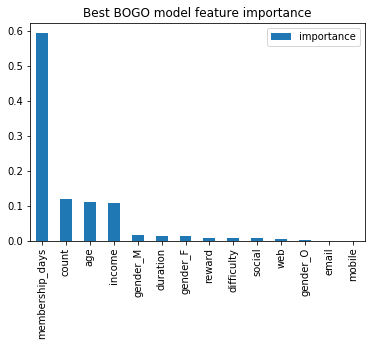

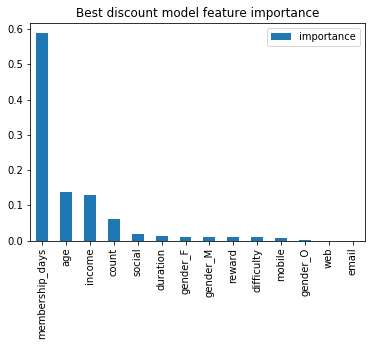

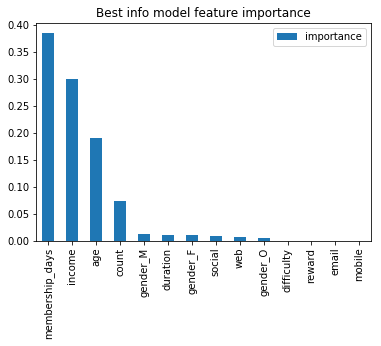

In [557]:
#BOGO 
feature_importances = pd.DataFrame(bogo_1.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best BOGO model feature importance')
plt.show()

#discount 
feature_importances = pd.DataFrame(discount_2.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best discount model feature importance')
plt.show()

#info
feature_importances = pd.DataFrame(info_1.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best info model feature importance')
plt.show()